In [1]:
import pandas as pd
import numpy as np
import os

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing text
import nltk
import re
import ssl 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# train test split
from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Reading Data

In [22]:
df = pd.read_csv("./data/Phish_No_More.csv")
df.shape

(39154, 7)

In [24]:
# Splitting 'sender' into 'name' and 'email'
df[['sender_name', 'sender_email']] = df['sender'].str.extract(r'(?P<name>.+?)\s*<(?P<email>.+?)>')

# Use the 'str.extract' method to create two new columns based on the pattern
df[['receiver_name', 'receiver_email']] = df['receiver'].str.extract(r'(?:(?P<receiver_name>.*)\s<)?(?P<receiver_email>[^<>]+)>?')

# Extracting the domain from 'sender_email'
df['sender_domain'] = df['sender_email'].str.extract(r'@(.+)', expand=False)

# Extracting the domain from 'receiver_email'
df['receiver_domain'] = df['receiver_email'].str.extract(r'@(.+)', expand=False)


In [25]:
# Converting 'date' to datetime format and forcing invalid formats to NaT
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)

# Dropping rows where 'date' is NaT (i.e., invalid datetime entries)
df = df.dropna(subset=['date'])

# Extracting year, month, day, hour from the 'date' column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

In [26]:
# Renaming 'urls' column to 'body_contains_url'
df.rename(columns={'urls': 'body_contains_url'}, inplace=True)

# Renaming 'label' column to 'is_fraud_email'
df.rename(columns={'label': 'is_fraud_email'}, inplace=True)

In [27]:
# Check for null values in the DataFrame
null_summary = df.isnull().sum()

# Display the columns with null values
print("Columns with null values:\n", null_summary[null_summary > 0])

Columns with null values:
 receiver             462
subject               28
sender_name         3454
sender_email        3454
receiver_name      32048
receiver_email       462
sender_domain       3456
receiver_domain      558
dtype: int64


In [28]:
# Drop rows where 'receiver', 'subject', or 'receiver_email' are null
df = df.dropna(subset=['receiver', 'subject', 'receiver_email'])

# Drop the 'receiver_name' column entirely due to high percentage of missing values
df = df.drop(columns=['receiver_name'])

# Drop rows where both 'sender_name' and 'sender_email' are null
df = df.dropna(subset=['sender_name', 'sender_email'], how='all')

# Optionally, drop rows where 'sender_domain' and 'receiver_domain' are null if domain analysis is important
df = df.dropna(subset=['sender_domain', 'receiver_domain'], how='any')

In [29]:
# Drop the specified columns
df = df.drop(columns=['sender', 'receiver'])

In [30]:
# Final df shape
df.shape

(35286, 14)

In [31]:
df.head()

,date,subject,body,is_fraud_email,body_contains_url,sender_name,sender_email,receiver_email,sender_domain,receiver_domain,year,month,day,hour
0,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,Young Esposito,Young@iworld.de,user4@gvc.ceas-challenge.cc,iworld.de,gvc.ceas-challenge.cc,2008,8,5,23
1,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,Mok,ipline's1983@icable.ph,user2.2@gvc.ceas-challenge.cc,icable.ph,gvc.ceas-challenge.cc,2008,8,5,23
2,2008-08-06 08:28:00+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,Daily Top 10,Karmandeep-opengevl@universalnet.psi.br,user2.9@gvc.ceas-challenge.cc,universalnet.psi.br,gvc.ceas-challenge.cc,2008,8,6,8
3,2008-08-05 23:31:20+00:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,Michael Parker,ivqrnai@pobox.com,xrh@spamassassin.apache.org,pobox.com,spamassassin.apache.org,2008,8,5,23
4,2008-08-05 23:31:21+00:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,Gretchen Suggs,externalsep1@loanofficertool.com,user2.2@gvc.ceas-challenge.cc,loanofficertool.com,gvc.ceas-challenge.cc,2008,8,5,23


In [32]:
df.isnull().sum()

date                 0
subject              0
body                 0
is_fraud_email       0
body_contains_url    0
sender_name          0
sender_email         0
receiver_email       0
sender_domain        0
receiver_domain      0
year                 0
month                0
day                  0
hour                 0
dtype: int64

## Pre-Preprocessing Data Visualisation

In [40]:
# Get counts of each 'Email Type'
email_type_counts = df["is_fraud_email"].value_counts().reset_index()

# Rename columns for clarity
email_type_counts.columns = ["Email Type", "Count"]

# Calculate total count of emails
total_count = email_type_counts["Count"].sum()

# Calculate percentages and round off to 1 decimal place
email_type_counts["Percentage"] = ((email_type_counts["Count"] / total_count) * 100).round(1)

# Display percentages as numeric with '%' symbol attached
email_type_counts["Percentage"] = email_type_counts["Percentage"].astype(str) + '%'

email_type_counts

,Email Type,Count,Percentage
0,1,20354,57.7%
1,0,14932,42.3%


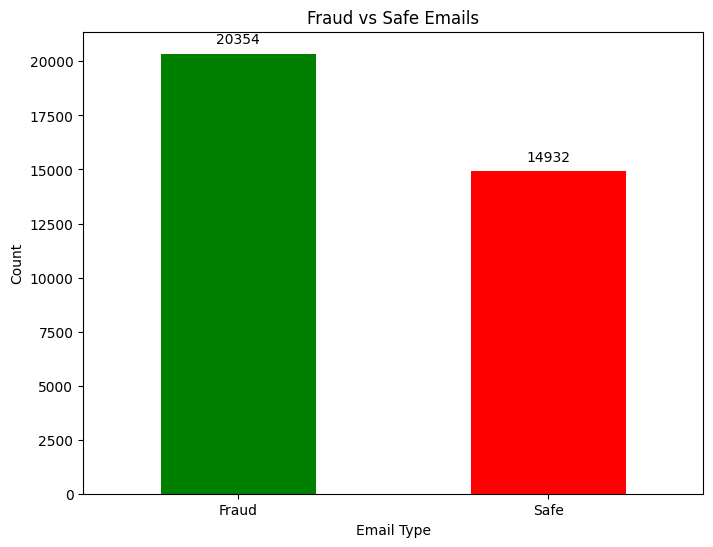

In [41]:
# Count the occurrences of each category in 'is_fraud_email'
fraud_counts = df['is_fraud_email'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = fraud_counts.plot(kind='bar', color=['green', 'red'])

# Adding title and labels
plt.title('Fraud vs Safe Emails')
plt.xlabel('Email Type')
plt.ylabel('Count')

# Add the count values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.xticks(ticks=[0, 1], labels=['Fraud', 'Safe'], rotation=0)
plt.show()


## Preprocessing Email Text

In [42]:
# Download nltk datasets

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jinge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jinge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jinge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jinge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Preprocess without lemmatization
Maintains contextual semantics and meaning

In [43]:
def preprocess_text(text: str) -> str:
    # Lowercase the text
    text = str(text).lower()
    
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Join the words back into a single string
    return ' '.join(words)

df['processed_text'] = df['body'].apply(preprocess_text)
df['processed_text']

0        buck troubles caused small dimension soon beco...
1        upgrade sex pleasures techniques httpwwwbright...
2        daily top cnncom top videos stories aug pm edt...
3        would anyone object removing list tld basicall...
4        welcomefastshippingcustomersupport httpiwfnabl...
                               ...                        
39149    cnn alerts custom alert alert name custom aler...
39150    cnn alerts custom alert alert name custom aler...
39151    hello great work slide show viewer application...
39152    mail sender coming intuitcom servers subject t...
39153    dear fellow pythonistas guido accepted user si...
Name: processed_text, Length: 35286, dtype: object

#### Preprocessing with lemmatization 
Simplifies text

In [9]:
def apply_lemmatization(text: str) -> str:
    words = text.split()
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into a single string
    return ' '.join(words)

df['processed_lemmatized_text'] = df['processed_text'].apply(apply_lemmatization)
df['processed_lemmatized_text']

0        disc uniformitarianism sex lang dick hudson ob...
1        side galicismos galicismo spanish term name im...
2        equistar deal ticket still available assist ro...
3        hello hot lil horny toy one dream open minded ...
4        software incredibly low price lower drapery se...
                               ...                        
18644    rick moen crit im confused thought gpled money...
18645    date lonely housewife always wanted date lonel...
18646    request submitted access request anita dupont ...
18647    important prc mtg hi dorn john discovered rece...
18648    press clipping letter californian utility plea...
Name: processed_lemmatized_text, Length: 17537, dtype: object

In [66]:
### Convert y to a binary variable ``
df['is_phishing_email'] = df['Email Type'].apply(lambda x: 1 if x == 'Phishing Email' else 0)


### Train Test Split

In [80]:
X = df[["Email Text", "processed_text", "processed_lemmatized_text"]]
y = df[["is_phishing_email"]]
# y = df[["Email Type"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Feature Engineering

### Using the Processed Lemmatized Text

#### Bag of Words

In [55]:
count_vectorizer = CountVectorizer()

X_train_bow = count_vectorizer.fit_transform(X_train['processed_lemmatized_text'])
X_test_bow = count_vectorizer.transform(X_test['processed_lemmatized_text'])

# X_train_bow_df = pd.DataFrame(X_train_bow.toarray(), columns=count_vectorizer.get_feature_names_out())
# X_train_bow_df

#### TF-IDF

In [56]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['processed_lemmatized_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['processed_lemmatized_text'])

# tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# tfidf_df

### Using the Processed Text without Lemmatization

#### Word2Vec

In [57]:
def get_average_vector(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:  # If no words are in the model's vocabulary
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [25]:
X_train['split_processed_text'] = X_train['processed_text'].apply(lambda x: x.split())
X_test['split_processed_text'] = X_test['processed_text'].apply(lambda x: x.split())

file_path = "./models/word2vec/word2vec.model"

if os.path.exists(file_path):
    word2vec_model = Word2Vec.load(file_path)
else:
    word2vec_model = Word2Vec(sentences=X_train["split_processed_text"].tolist(), vector_size=100, window=5, min_count=1, workers=4)
    word2vec_model.save(file_path)

X_train_word2vec_embedding = X_train['split_processed_text'].apply(lambda x: get_average_vector(x, word2vec_model))
X_test_word2vec_embedding = X_test['split_processed_text'].apply(lambda x: get_average_vector(x, word2vec_model))

pd.DataFrame(X_train_word2vec_embedding)

# Convert Word2Vec lists to numpy arrays
X_train_word2vec = np.array(X_train_word2vec_embedding.tolist())
X_test_word2vec = np.array(X_test_word2vec_embedding.tolist())

#### Sentence Transformers - MPNet

In [16]:
file_path_train = "./models/sentence_transformer/train_embeddings.npy"
file_path_test = "./models/sentence_transformer/test_embeddings.npy"

# Check if the file exists
if (os.path.exists(file_path_train) and os.path.exists(file_path_test)):
    train_embeddings = np.load(file_path_train)
    test_embeddings = np.load(file_path_test)
else:
    # Load the MPNet model
    sentence_transformer_model = SentenceTransformer('all-mpnet-base-v2')

    # Encode the texts
    train_embeddings = sentence_transformer_model.encode(X_train["processed_text"].tolist())
    test_embeddings = sentence_transformer_model.encode(X_test["processed_text"].tolist())

    np.save(file_path_train, train_embeddings)
    np.save(file_path_test, test_embeddings)

pd.DataFrame(train_embeddings)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.055215,0.040998,0.018498,-0.040737,-0.016033,0.013414,0.025461,0.024051,-0.008673,-0.004123,...,-0.006968,-0.011935,-0.032153,0.004473,0.013275,-0.046424,-0.035631,-0.028987,0.015999,-0.035582
1,-0.018762,0.031979,-0.009991,0.050318,-0.051733,0.017979,-0.026342,-0.015399,-0.000099,0.013546,...,0.042102,-0.029738,0.073981,0.013796,-0.042955,0.027119,0.001304,-0.002337,-0.073789,-0.045240
2,-0.063565,0.011312,-0.002446,0.023005,-0.002710,-0.004180,0.047600,-0.034768,0.021258,-0.020148,...,-0.057920,-0.043214,-0.021039,0.011102,0.041032,-0.029031,-0.021433,-0.015719,-0.085551,-0.005109
3,-0.002756,0.099910,0.009682,-0.028605,-0.058711,0.001223,0.080495,0.035834,-0.068889,-0.042703,...,-0.022554,-0.013521,-0.015925,-0.019768,-0.013781,0.050030,-0.035885,-0.052041,-0.013069,-0.002563
4,0.066307,0.030267,0.011326,-0.011726,0.046341,-0.014928,-0.007289,0.102103,0.056611,0.009897,...,-0.035150,0.007406,0.009452,-0.005577,0.025738,-0.000796,-0.036657,-0.011133,-0.058493,-0.055478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14024,-0.012147,0.014379,-0.010492,0.029231,-0.034395,0.023270,0.014731,0.019841,-0.032777,-0.041586,...,0.040567,-0.007215,0.037140,0.023957,-0.025979,-0.023699,-0.016421,-0.052483,-0.057440,-0.020690
14025,0.034811,0.020651,-0.039927,0.026024,-0.031407,-0.018016,-0.016431,0.001573,-0.037627,-0.081984,...,-0.012607,0.048493,0.019728,0.021103,0.013198,0.003722,0.037708,0.013326,0.019227,0.005928
14026,0.050375,0.040112,-0.009396,-0.010274,-0.032341,0.029878,-0.025951,0.031843,-0.019983,-0.013341,...,0.027413,-0.031122,0.038098,0.014792,-0.022389,0.026915,-0.000056,-0.022191,0.003011,-0.021948
14027,0.038098,0.087238,0.013788,-0.000910,-0.003929,-0.013574,0.020706,0.086258,0.029944,-0.000807,...,0.012338,-0.007831,0.017063,0.005898,0.002275,0.057699,0.016942,0.013475,-0.023272,-0.004465


## Post Processing Data Visualisation

some thoughts and recommendations I found online
- for word2vec specifically, L6 there's this word2vec visualisation with an axis and words. could consider doing these?
- PCA / TSNE (vaguely recall reading this)
- wordcloud maybe for bag of words & tfidf? 
- Cosine Similarity Heatmap

# Support Vector Machine

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

## Run Models Individually (SVM)

### Bag of Words

In [28]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(X_train_bow, y_train)

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(X_test_bow)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9680729760547321
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.95      0.96      0.96      1311
    Safe Email       0.98      0.97      0.97      2197

      accuracy                           0.97      3508
     macro avg       0.96      0.97      0.97      3508
  weighted avg       0.97      0.97      0.97      3508



### TF-IDF

In [21]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(X_train_tfidf, y_train.values.ravel())  # Use ravel() to avoid issues with shape

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(X_test_tfidf)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9846066134549601
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.98      0.98      0.98      1311
    Safe Email       0.99      0.99      0.99      2197

      accuracy                           0.98      3508
     macro avg       0.98      0.98      0.98      3508
  weighted avg       0.98      0.98      0.98      3508



### Word2Vec

In [23]:
# # Step 1: Convert the lists of embeddings to numpy arrays
# X_train_word2vec = np.array(X_train_word2vec_embedding.tolist())
# X_test_word2vec = np.array(X_test_word2vec_embedding.tolist())

# # Step 2: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 3: Train the SVM model
# svm_model.fit(X_train_word2vec, y_train)

# # Step 4: Make predictions on the test set
# y_pred = svm_model.predict(X_test_word2vec)

# # Step 7: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9592360319270239
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.95      0.94      0.95      1311
    Safe Email       0.96      0.97      0.97      2197

      accuracy                           0.96      3508
     macro avg       0.96      0.96      0.96      3508
  weighted avg       0.96      0.96      0.96      3508



### Sentence Transformer

In [24]:
# # Step 1: Initialize the SVM classifier
# svm_model = SVC(kernel='linear', random_state=1)

# # Step 2: Train the SVM model
# svm_model.fit(train_embeddings, y_train.values.ravel())  # Use ravel() to avoid issues with shape

# # Step 3: Make predictions on the test set
# y_pred = svm_model.predict(test_embeddings)

# # Step 4: Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9543899657924744
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.94      0.93      0.94      1311
    Safe Email       0.96      0.97      0.96      2197

      accuracy                           0.95      3508
     macro avg       0.95      0.95      0.95      3508
  weighted avg       0.95      0.95      0.95      3508



## Run all (SVM)

In [34]:
# Step 1: Collect results
results = []

# Step 2: Define a function to train SVM and evaluate
def run_svm(X_train, X_test, y_train, y_test, feature_name):
    svm_model = SVC(kernel='linear', random_state=1)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report['Phishing Email']['f1-score'], report['Safe Email']['f1-score']  # Adjust 'spam'/'non-spam' according to your labels

# Run SVM for each feature set
feature_sets = {
    "Bag of Words": (X_train_bow, X_test_bow),
    "TF-IDF": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_word2vec, X_test_word2vec),
    "Sentence Transformer": (train_embeddings, test_embeddings)
}

for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
    accuracy, spam_f1, non_spam_f1 = run_svm(X_train_feature, X_test_feature, y_train, y_test, feature_name)
    results.append({
        "Feature Set": feature_name,
        "Accuracy": accuracy,
        "Phishing Email F1 Score": spam_f1,
        "Safe Email F1 Score": non_spam_f1
    })

# Step 3: Create a DataFrame to represent the results
results_df = pd.DataFrame(results)

# Step 4: Display the results
print(results_df)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-v

            Feature Set  Accuracy  Phishing Email F1 Score  \
0          Bag of Words  0.968073                 0.957608   
1                TF-IDF  0.984607                 0.979421   
2              Word2Vec  0.959236                 0.945148   
3  Sentence Transformer  0.954390                 0.938603   

   Safe Email F1 Score  
0             0.974394  
1             0.987705  
2             0.967566  
3             0.963719  


In [35]:
results_df

,Feature Set,Accuracy,Phishing Email F1 Score,Safe Email F1 Score
0,Bag of Words,0.968073,0.957608,0.974394
1,TF-IDF,0.984607,0.979421,0.987705
2,Word2Vec,0.959236,0.945148,0.967566
3,Sentence Transformer,0.954390,0.938603,0.963719


# Random Forest

In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


## Run Models Individually (SVM)

### Bag of Words

In [37]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_bow, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_bow)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9718
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.97      0.96      0.96      1311
    Safe Email       0.97      0.98      0.98      2197

      accuracy                           0.97      3508
     macro avg       0.97      0.97      0.97      3508
  weighted avg       0.97      0.97      0.97      3508



### TF-IDF

In [38]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_tfidf, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_tfidf)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9729
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.97      0.95      0.96      1311
    Safe Email       0.97      0.98      0.98      2197

      accuracy                           0.97      3508
     macro avg       0.97      0.97      0.97      3508
  weighted avg       0.97      0.97      0.97      3508



### Word2Vec

In [39]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(X_train_word2vec, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(X_test_word2vec)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9624
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.96      0.94      0.95      1311
    Safe Email       0.97      0.97      0.97      2197

      accuracy                           0.96      3508
     macro avg       0.96      0.96      0.96      3508
  weighted avg       0.96      0.96      0.96      3508



### Sentence Transformer

In [40]:
# # Step 1: Train the Random Forest model
# rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
# rf_model.fit(train_embeddings, y_train)

# # Step 2: Make predictions
# y_pred = rf_model.predict(test_embeddings)

# # Step 3: Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# # Print results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)

c:\Users\jinge\Desktop\BT4012\Fraud-Email\.venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9438
Classification Report:
                 precision    recall  f1-score   support

Phishing Email       0.97      0.88      0.92      1311
    Safe Email       0.93      0.98      0.96      2197

      accuracy                           0.94      3508
     macro avg       0.95      0.93      0.94      3508
  weighted avg       0.95      0.94      0.94      3508



## Run all (Random Forest)

In [84]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Collect results
results = []

# Step 2: Define a function to train Random Forest and evaluate
def run_random_forest(X_train, X_test, y_train, y_test, feature_name):
    rf_model = RandomForestClassifier(random_state=1)  # You can adjust hyperparameters as needed
    rf_model.fit(X_train, y_train.values.ravel())
    y_pred = rf_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report['1']['f1-score'], report['0']['f1-score']  # Adjust 'Phishing Email'/'Safe Email' according to your labels

# Run Random Forest for each feature set
feature_sets = {
    "Bag of Words": (X_train_bow, X_test_bow),
    "TF-IDF": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_word2vec, X_test_word2vec),
    "Sentence Transformer": (train_embeddings, test_embeddings)
}

for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
    accuracy, phishing_f1, safe_f1 = run_random_forest(X_train_feature, X_test_feature, y_train, y_test, feature_name)
    results.append({
        "Feature Set": feature_name,
        "Accuracy": accuracy,
        "Phishing Email F1 Score": phishing_f1,
        "Safe Email F1 Score": safe_f1
    })

# Step 3: Create a DataFrame to represent the results
results_df = pd.DataFrame(results)

# Step 4: Display the results
print(results_df)


            Feature Set  Accuracy  Phishing Email F1 Score  \
0          Bag of Words  0.970353                 0.959969   
1                TF-IDF  0.972064                 0.962074   
2              Word2Vec  0.962942                 0.950038   
3  Sentence Transformer  0.941277                 0.917069   

   Safe Email F1 Score  
0             0.976460  
1             0.977888  
2             0.970548  
3             0.954545  


In [85]:
results_df

,Feature Set,Accuracy,Phishing Email F1 Score,Safe Email F1 Score
0,Bag of Words,0.970353,0.959969,0.976460
1,TF-IDF,0.972064,0.962074,0.977888
2,Word2Vec,0.962942,0.950038,0.970548
3,Sentence Transformer,0.941277,0.917069,0.954545


# XGBoost

## Run Models Individually (XGBoost)

In [72]:
from xgboost import XGBClassifier

### Bag of Words

In [78]:
# Step 1: Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder = True, eval_metric='mlogloss', random_state=1)

# Step 2: Train the model
xgb_model.fit(X_train_bow, y_train)

# # Step 3: Make predictions on the test set
y_pred = xgb_model.predict(X_test_bow)

# # Step 4: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Phishing Email' 'Safe Email']

### TF-IDF

In [73]:
# Step 1: Initialize the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1)

# Step 2: Train the model
xgb_model.fit(X_train_tfidf, y_train)

# # Step 3: Make predictions on the test set
y_pred = xgb_model.predict(X_test_tfidf)

# # Step 4: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9632269099201825
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2197
           1       0.95      0.95      0.95      1311

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



### Word2Vec

In [74]:
# Step 1: Initialize the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1)

# Step 2: Train the model
xgb_model.fit(X_train_word2vec, y_train)

# # Step 3: Make predictions on the test set
y_pred = xgb_model.predict(X_test_word2vec)

# # Step 4: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9692132269099202
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      2197
           1       0.96      0.96      0.96      1311

    accuracy                           0.97      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.97      0.97      0.97      3508



### Sentence Transformer

In [75]:
# Step 1: Initialize the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1)

# Step 2: Train the model
xgb_model.fit(train_embeddings, y_train)

# # Step 3: Make predictions on the test set
y_pred = xgb_model.predict(test_embeddings)

# # Step 4: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9620866590649944
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      2197
           1       0.96      0.94      0.95      1311

    accuracy                           0.96      3508
   macro avg       0.96      0.96      0.96      3508
weighted avg       0.96      0.96      0.96      3508



## Run all (XGBoost)

In [81]:
from xgboost import XGBClassifier

# Step 1: Collect results
results = []

# Step 2: Define a function to train XGBoost and evaluate
def run_xgboost(X_train, X_test, y_train, y_test, feature_name):
    xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=1)
    xgb_model.fit(X_train, y_train.values.ravel())
    y_pred = xgb_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report['1']['f1-score'], report['0']['f1-score']  # Adjust 'Phishing Email'/'Safe Email' according to your labels

# Run XGBoost for each feature set
feature_sets = {
    "Bag of Words": (X_train_bow, X_test_bow),
    "TF-IDF": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_word2vec, X_test_word2vec),
    "Sentence Transformer": (train_embeddings, test_embeddings)
}

for feature_name, (X_train_feature, X_test_feature) in feature_sets.items():
    accuracy, phishing_f1, safe_f1 = run_xgboost(X_train_feature, X_test_feature, y_train, y_test, feature_name)
    results.append({
        "Feature Set": feature_name,
        "Accuracy": accuracy,
        "Phishing Email F1 Score": phishing_f1,
        "Safe Email F1 Score": safe_f1
    })

# Step 3: Create a DataFrame to represent the results
results_df = pd.DataFrame(results)

# Step 4: Display the results
print(results_df)


            Feature Set  Accuracy  Phishing Email F1 Score  \
0          Bag of Words  0.968928                 0.958696   
1                TF-IDF  0.963227                 0.951006   
2              Word2Vec  0.969213                 0.958747   
3  Sentence Transformer  0.962087                 0.948668   

   Safe Email F1 Score  
0             0.975097  
1             0.970568  
2             0.975443  
3             0.969944  


In [82]:
results_df

,Feature Set,Accuracy,Phishing Email F1 Score,Safe Email F1 Score
0,Bag of Words,0.968928,0.958696,0.975097
1,TF-IDF,0.963227,0.951006,0.970568
2,Word2Vec,0.969213,0.958747,0.975443
3,Sentence Transformer,0.962087,0.948668,0.969944
